# Aimlytics


Import libraries


In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

## Image Acquisition and Pre-processing
We want to obtain a clear image, ready to be analyzed.

(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

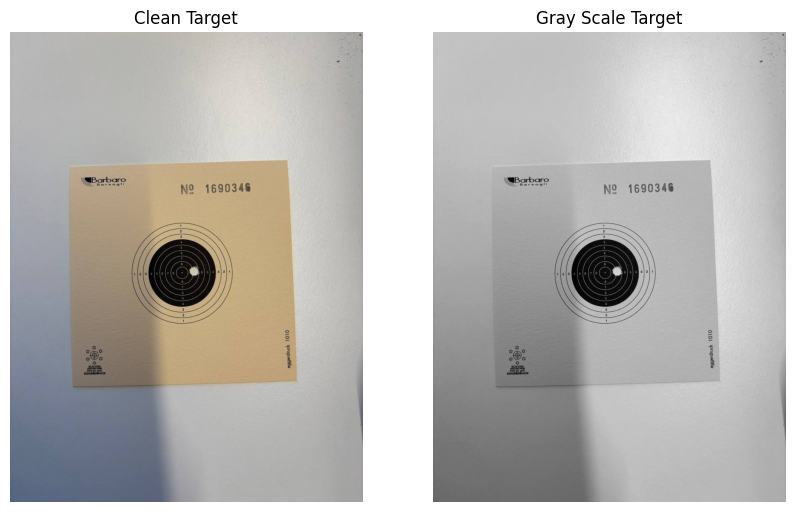

In [17]:
image = cv2.imread("target_images/photo_2025-02-27_14-20-40.jpg")
RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.show()
plt.subplot(121)
plt.title("Clean Target")
plt.imshow(RGB_image)
plt.axis('off')
plt.subplot(122)
plt.title("Gray Scale Target")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')


- Filter noise with **GaussianBlur** and **bilateralFilter** filters. The first one reduces noise and softens edges, the second one, particularly useful when working with the detection of circular elements, further reduces noise while preserving important edges.

- Improve Canny edge detection by locally adjusting the threshold. It's useful to enhance contrast and separate bullet holes from the background. Converts the smoothed image into a binary image.

- Remove noise from the binary image with an *opening morphology operation* (a dilation followed by an erosion, image below). It's useful to fill possible gaps in white areas and then remove noise.

![](jupyter_images/opening_opencv_documentation.png)




(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

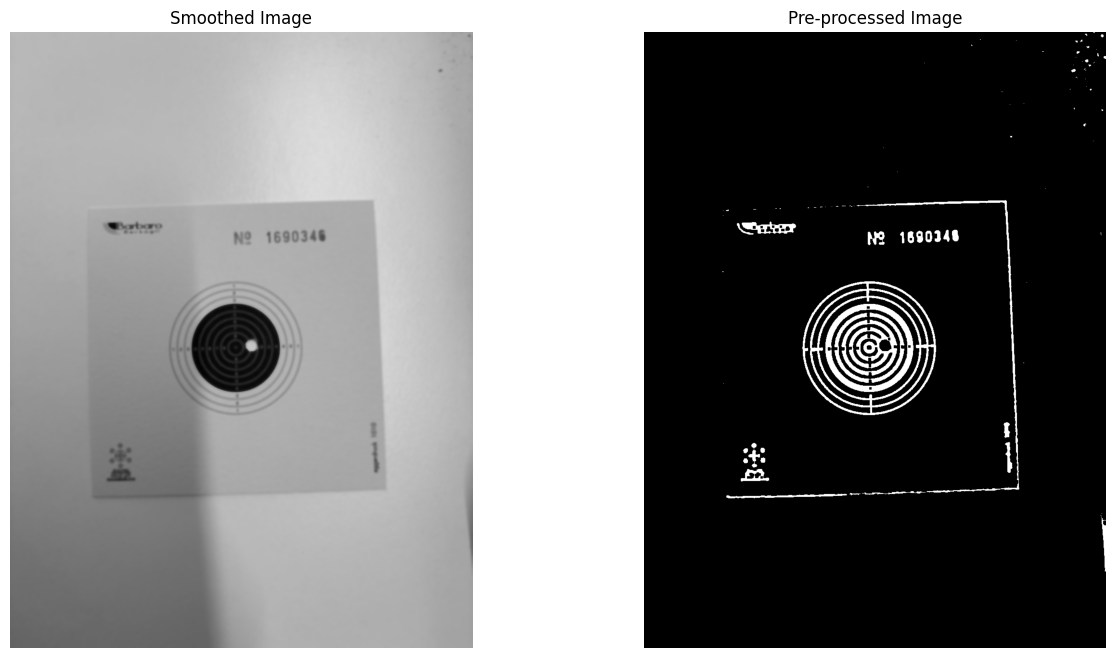

In [26]:
smoothed_image_gauss = cv2.GaussianBlur(gray_image, (5, 5), 0)
#Applied to the grayscale image; 5-by-5 kernel to determine the area of neighboring pixels; 0 to let opencv determine the standard deviation
smoothed_image_bi = cv2.bilateralFilter(smoothed_image_gauss, 9, 75, 75)
#9-by-9 kernel; 75 for the standard deviations of intensity and spatial filtering


binary_image = cv2.adaptiveThreshold(smoothed_image_bi, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, thresholdType=cv2.THRESH_BINARY_INV, blockSize=11, C=2)
#ADAPTIVE_THRESH_GAUSSIAN_C to use a Gaussian weighted neighborhood
#THRESH_BINARY_INV inverts the result (white foreground and black background)
#11 is the region size for the local thresholding; 2 is a constant subtracted from the mean to fine-tune the threshold

kernel = np.ones((3, 3), np.uint8)      #Create a 3-by-3 kernel
cleaned_binary = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel, iterations=2)      #Opening operation applied 2 times

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.title("Smoothed Image")
plt.imshow(cv2.cvtColor(smoothed_image_bi,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.title("Pre-processed Image")
plt.imshow(cv2.cvtColor(cleaned_binary,cv2.COLOR_BGR2RGB))
plt.axis('off')

## Target Recognition

Perform Canny edges detection and then create a bounding box around the outer target circle. So the target detection is obtained.

(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

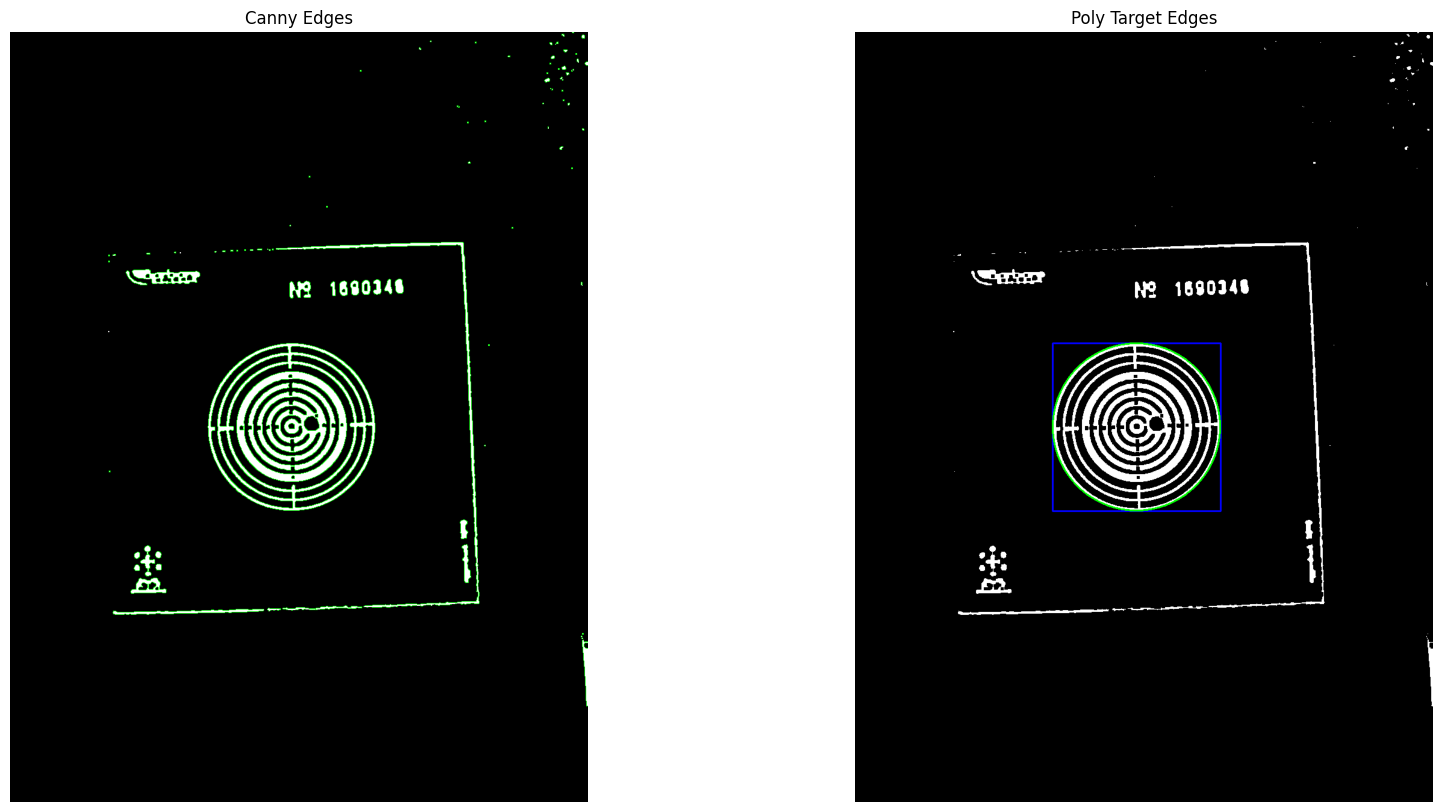

In [31]:
#Canny code
edgeresult = np.copy(cleaned_binary)    #Creating an image copy to draw edges on
edgeresult = cv2.cvtColor(edgeresult, cv2.COLOR_GRAY2BGR)   #Converting it to grayscale for canny detection

th1, th2 = 30, 120  #Canny recommends threshold 2 is 3 times threshold 1
edges = cv2.Canny(cleaned_binary, th1, th2)
edgeresult[edges != 0] = (0, 255, 0)  #Highlight edges: takes pixels in edgeresult and where edge is non-zero it is coloured with green


#Bounding box code
#Find the bigger contour assuming it's the outer circle of the target
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#Obtain the bounding box contours and the biggest circle contour by choosing the contours enclosing the largest area
max_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(max_contour)
(xc, yc), radius = cv2.minEnclosingCircle(max_contour)
center = (int(xc), int(yc))
radius = int(radius)

#Another image copy to draw on
bounding_rect = np.copy(cleaned_binary)
bounding_rect = cv2.cvtColor(bounding_rect, cv2.COLOR_GRAY2BGR)

#Draw the bounding box on the target in blue and the outer circle edge in green
drawing = cv2.rectangle(bounding_rect, (x, y), (x + w, y + h), (255, 0, 0), 2)
drawing = cv2.circle(drawing, center, radius, (0, 255, 0), 2)


plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.title("Canny Edges")
plt.imshow(cv2.cvtColor(edgeresult, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.title("Poly Target Edges")
plt.imshow(cv2.cvtColor(drawing, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Transform Perspective
- Correct perspective with warpPerspective() (DINAMICAMENTE solo dopo rilevamento cerchio bersaglio)

<Axes: >

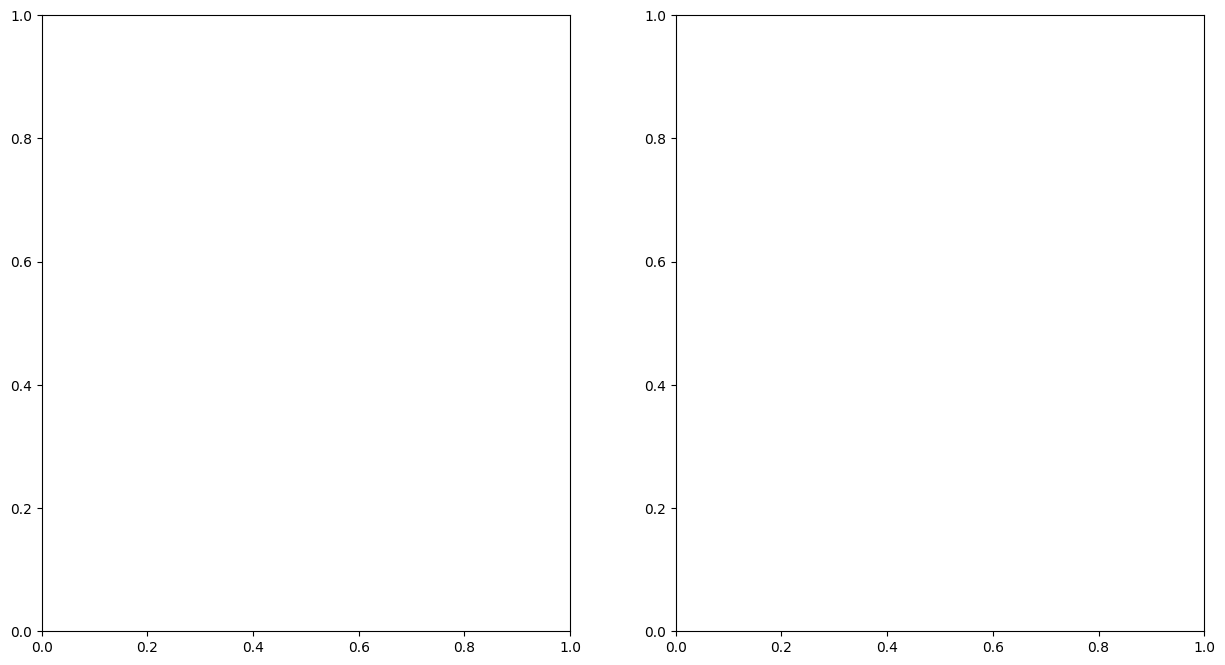

In [20]:
#inserisci funz per rilevare e traformare bersagli con foto storta
# pts1 = np.float32([[219,209],[612,8],[380,493],[785,271]])
# # Size of the Transformed Image
# pts2 = np.float32([[0,0],[500,0],[0,400],[500,400]])
#
# perspective_matrix = cv2.getPerspectiveTransform(pts1, pts2)
# corrected_perspective_image = cv2.warpPerspective(image, perspective_matrix, image.shape[1::-1])


plt.figure(figsize=(15, 8))
plt.subplot(121)
# plt.title("Input Image")
# plt.imshow(cv2.cvtColor(,cv2.COLOR_BGR2RGB))
# plt.axis('off')
plt.subplot(122)
# plt.title("Corrected Perspective")
# plt.imshow(cv2.cvtColor(,cv2.COLOR_BGR2RGB))
# plt.axis('off')

## Detect bullet holes


# Assign score